In [1]:
# Imports
import numpy as np
import pandas as pd
import pyspark
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import contractions
import math
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.stem import WordNetLemmatizer

import re
import string
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from google.cloud import bigquery

from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
GROUP_CUSTOM_STOPWORDS = [
    "bike", "nbsp", "crn","sample", "bikes", "great", "good", "love","like", "recommend","smells","collected","part","review","promotion","razor",
    "shave","shaving","blade","camille","cantu","daughter","today","kccc","jessie","miss","fabric","pillow","softener","or",    "tiktok","OR",
     'Proov', 'proov','Natalist', 'natalist','Stix', 'stix','Clear Blue', 'blue','Modern Fertility', 'modern', 'free', 'app', 'mf', 'android', 'pinchme',
    'Pregmate', 'pregmate', 'received','First Response', 'test', 'ovulation', 'none', 'see', 'store', 'day', 'month', 'amy', 'face', 'far', 'scan',
    'it‚äôs','don‚äôt', 'using_minoxidil', '_oz','i‚äôm','moreread','using','stating',
    'doesn‚äôt', 'classic','order','ordering', 'best', 'hard', 'seltzer', 'claw','never','got','ordered','white','product','high-noon','bottle','girl',
    'read_lessread','read_moreread','lessread_le','le_stating','moreread_stating','scalp detox','le_serum',
    'moreread_serum','i’ve_stem','hair_read','don’t_know','i’ve_bought', 'liquid_kinda', "i'ḿ"'use_serum','le_mus','read_serum','ingredient_us','oz_extreme',
    'cell_serum','cell','stem','le','read','lessread','moreread','more','multi-colored—from_brown','findin_read','strengthening_hair','hair_oil','care_oil',
    'hair','oil_hair','extreme_hair','hair_care','extreme','oz','_strengthening','used twice', 'oil_oil', 'customer',    'nan', 'read_moreread', 'noreferrer',
    'noreferrer_farmer','farmer_dog/a','noreferrer_ollie/a','rel','noopener','blank_rel',
    'rel_nofollow','blank','nofollow','target_blank','noopener_noreferrer','nofollower_noopener','nofollow_noopener',"partake","partake_cooky", "crunchy_cooky","cooky_vegan","madegood","apple_jack"
]

added_stopwords_li = [
    "it’s",    "'d",    "'s",
    "n't",    "'m",
    "i've",    "it's",    "'ve",
    "'re",    "'ll",    "``",    "''",    "...",    "--", "https",
    "voxbox",    "influenster",    "cracker",    "or",    'it‚äôs',
    'don‚äôt',    'i‚äôm',    'doesn‚äôt',    "get", "also",    "even",    "since", "amy"
]

REV_COLS = ['source_name',
    'normalized_url',
    'review_source_id',
    'reviewer_source_id',
    'brand_name',
    'product_name',
    'product_source_id',
    'review_date',
    'review_rating',
    'review_content'
]

product_categories = ['Accessories',
'Alcoholic Beverages',
'Apparel & Footwear',
'Food',
'Food Establishments',
'Health & Beauty Establishments',
'Household Consumables',
'Household Durables',
'Other',
'Pet Products',
'Non-Alcoholic Beverages',
'Personal Care & Beauty',
'Retailers',
'Sports & Outdoors'
]

drop_words = ["’",
              
             ]

MIN_TERM_PCT = 0

MAX_TERM_PCT = 100

TERM_PERCENT_HEAD = 1

TOP_N_WORDS = 8

np.random.seed(42) # set seed for models for reproducibility

stopwords_li = stopwords.words('english')
punkts_li = list(string.punctuation)

REVIEWS_PER_BRAND_TO_ANALYZE = 10_000

In [62]:
def tokenize(s, strip_str="=-_/\+.:,'* 1234567890—"):
    custom_words_li = GROUP_CUSTOM_STOPWORDS + added_stopwords_li+stopwords_li + punkts_li + [""]
    return [w.lower().strip(strip_str) for w in word_tokenize(str(s)) if w.lower().strip(strip_str) not in custom_words_li]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

def unique_list(li):
    deduped_li = list(set(li))
    return deduped_li

def bigram(tokens):
    bi_tup = list(bigrams(tokens))
    bi_li = ['_'.join(tup) for tup in bi_tup]
    return bi_li


In [91]:
reviews = pd.read_csv("smartsweets_project7_reviews.csv")

#negative reviews only
reviews = reviews[reviews["review_rating"]<4]

In [92]:
tokenized_reviews = reviews.copy()
tokenized_reviews['tokenized_review'] = tokenized_reviews['review_content'].apply(lambda x: lemmatize(tokenize(x)))
tokenized_reviews = tokenized_reviews.dropna(subset=['tokenized_review'])

In [93]:
unibi_reviews = tokenized_reviews.copy()

unibi_reviews['unibi'] = unibi_reviews['tokenized_review'].apply(lambda x: unique_list(bigram(x)+x))
unibi_reviews = unibi_reviews.loc[unibi_reviews.astype(str).drop_duplicates().index]

unibi_words = unibi_reviews.copy()
unibi_words['unibi_word'] = unibi_words['unibi']
unibi_words = unibi_words.explode('unibi_word')
unibi_words = unibi_words[~unibi_words["unibi_word"].isin(drop_words)]
#unibi_words=unibi_words[unibi_words["parent_category"]=="Food"]

In [94]:
common_phrases_smartsweets = unibi_words[unibi_words["normalized_url"]=="smartsweets.com"]["unibi_word"].value_counts().head(10).to_frame('counts').reset_index()

In [95]:
review_rating = unibi_words.groupby(["normalized_url","unibi_word"])["review_rating"].mean().reset_index()

In [96]:
smartsweets_di = dict(zip(review_rating[review_rating["normalized_url"]=="smartsweets.com"]["unibi_word"],review_rating[review_rating["normalized_url"]=="smartsweets.com"]["review_rating"]))
common_phrases_smartsweets["avg_rating"] = common_phrases_smartsweets["index"].map(smartsweets_di)

In [97]:
common_phrases_project7= unibi_words[unibi_words["normalized_url"]=="project7.com"]["unibi_word"].value_counts().head(10).to_frame('counts').reset_index()

In [98]:
project7_di = dict(zip(review_rating[review_rating["normalized_url"]=="project7.com"]["unibi_word"],review_rating[review_rating["normalized_url"]=="project7.com"]["review_rating"]))
common_phrases_project7["avg_rating"] = common_phrases_project7["index"].map(project7_di)

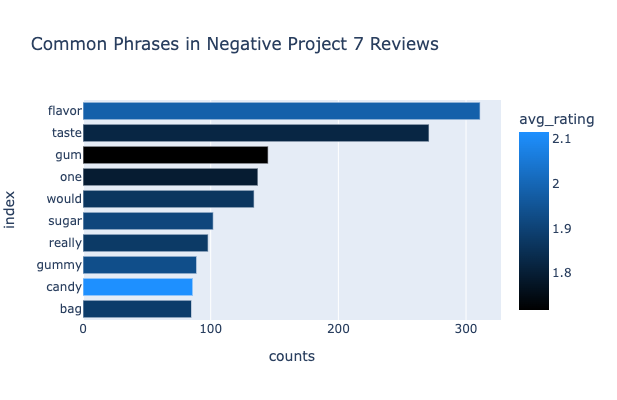

In [101]:
fig = px.bar(common_phrases_project7, x="counts", y="index", color='avg_rating', orientation='h',
             height=400,
             title='Common Phrases in Negative Project 7 Reviews',
             color_continuous_scale = ['#000000','#1E90FF']
            )
fig.update_yaxes(autorange="reversed")
fig.show()


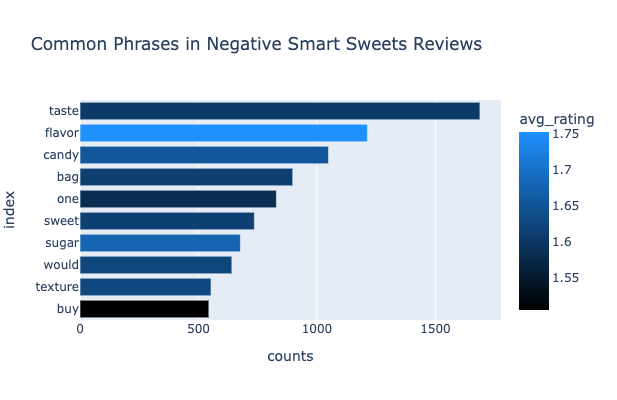

In [102]:
fig = px.bar(common_phrases_smartsweets, x="counts", y="index", color='avg_rating', orientation='h',
             height=400,
             title='Common Phrases in Negative Smart Sweets Reviews',
             color_continuous_scale = ['#000000','#1E90FF']
            )
fig.update_yaxes(autorange="reversed")
fig.show()
